# Poly2Graph Tutorial

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import networkx as nx
import torch

import poly2graph as p2g
from poly2graph import dataset as D

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:', device)
print('torch version:', torch.__version__)

print('p2g version:', p2g.__version__)
print('available functions:', p2g.__all__)

device: cuda
torch version: 2.4.1+cu118
p2g version: 0.0.5
available functions: ['angle_between_vecs', 'LG_undirected', 'poly_roots_tf_batch', 'poly_roots_torch_batch', 'poly_to_H_1band', 'real_space_spectra_1band', 'skeleton2graph', 'mark_node', 'draw_graph_on_skeleton', 'auto_Emaxes', 'minmax_normalize', 'PosGoL', 'spectral_potential', 'spectral_images_adaptive_resolution', 'delete_iso_nodes', 'contract_close_nodes', 'spectral_graph', 'draw_image', 'dataset', 'AttentiveGnLConv', 'GnLTransformer_Paired', 'GnLTransformer_Hetero', 'XAGnLConv', 'XGnLTransformer_Paired', 'normalize_color', 'visualize_attention_scores', 'visualize_node_embeddings', 'ExplanationSummary', '__version__']


## Spectral Graph Construction (One-Band)

Take a one-band characteristic polynomial as an example:
$$P(E,z) = -z^{-2} - E - z + z^4$$
its coefficient list is `c = [0, 0, -1, 0, 0, -1, 0, 0, 1]`. `poly2graph` only takes in **symmetric** coefficient list where the middle element is the constant term (i.e. the coefficient of $z^0$). This is how `poly2graph` identifies the degree range.

In [19]:
### coefficient list (symmetrically formatted)
c = np.array([0, 0, -1, 0, 0, -1, 0, 0, 1])

Call `spectral_graph` with the coefficient list `c` and the energy range `E_max`, it will return the spectral graph as a networkx multigraph object.

The complex energy domain should be square grid that contains the spectral graph. The parameter `E_max` could be a list of 4 real numbers that specifies 
$$[\text{Re}(E)_\text{min}, \text{Re}(E)_\text{max}, \text{Im}(E)_\text{min}, \text{Im}(E)_\text{max}]$$
or a single real number which will be interpreted as
$$E_\text{max}=\text{Re}(E)_\text{max}=\text{Re}(E)_\text{min}=\text{Im}(E)_\text{max}=\text{Im}(E)_\text{min}$$

The recommended way is to call `auto_Emaxes` to automatically determine the energy range (but so far it only supports one-band polynomial). Pass `c` as a `numpy.array`; otherwise, numba will raise an error.

Re(E) (min): -2.4020020322545883   Re(E) (max): 2.5671486238803536
Im(E) (min): -2.4845753280674696   Im(E) (max): 2.4845753280674723

Object type: <class 'networkx.classes.multigraph.MultiGraph'>


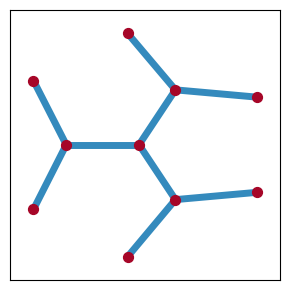

In [20]:
### automatic boundaries of the energy grid
# `c` should be numpy array if `auto_Emaxes` is called
# otherwise numba will raise an error
E_maxes = p2g.auto_Emaxes(c)
print('Re(E) (min):', E_maxes[0], '  Re(E) (max):', E_maxes[1])
print('Im(E) (min):', E_maxes[2], '  Im(E) (max):', E_maxes[3])

### spectral graph
sg = p2g.spectral_graph(c, E_max=E_maxes)
print('\nObject type:', type(sg))

### plot spectral graph
fig, ax = plt.subplots(figsize=(3, 3))
pos_dict = {i[0]: (i[1][1], i[1][0]) for i in sg.nodes(data='o')}
nx.draw_networkx(sg, pos=pos_dict, ax=ax,
                 node_size=50, node_color='#A60628', with_labels=False, 
                 width=5, edge_color='#348ABD')
plt.tight_layout()
# plt.savefig('./assets/spectral_graph_one_band.pdf', transparent=True)
plt.savefig('./assets/spectral_graph_one_band.png', dpi=300, transparent=True)
plt.show()

Let us diagonalize a real-space Hamiltonian to verify the spectral graph overlaps with the energy spectrum in thermodynamic limit ($L\to\infty$), and visualize the density of states (DOS) in TDL (see the companion paper for details).

The DOS, $\rho(E)$, is proportional to the lapaclacian of the spectral potential, $\Phi(E)$:
$$\rho(E) = -\frac{1}{2\pi} \Delta \Phi(E)$$
$\Delta = \partial_{\text{Re} E}^2 + \partial_{\text{Im} E}^2$ is the Laplacian operator on the complex energy plane. Laplacian operator extracts curvature; thus, geometrically speaking, the loci of spectral graph $\mathcal{G}$ resides on the *ridges* of the Coulomb potential landscape.

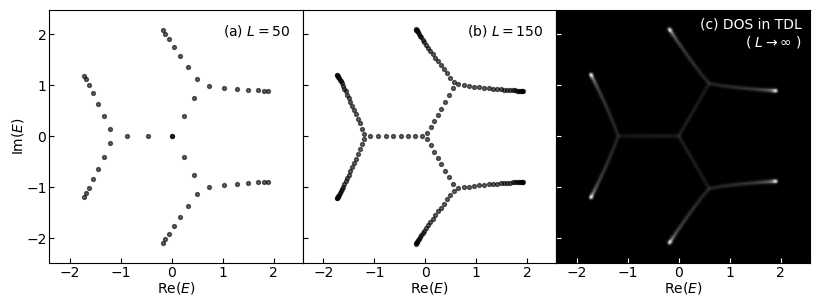

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(8,3), sharex=True, sharey=True,
                       gridspec_kw={'hspace':.0, 'wspace':.0})

num_sites = [50, 150]
for i, num_site in enumerate(num_sites):
    ### the spectrum of a finite real-space Hamiltonian
    energies = p2g.real_space_spectra_1band(c, num_site)
    ax[i].scatter(*energies, s=8, c='k', alpha=.6)
    ax[i].set(aspect='equal', xlim=E_maxes[:2], ylim=E_maxes[2:])
    ax[i].text(.95, .95, f'({chr(97+i)}) $L = {num_site}$',
                ha='right', va='top', transform=ax[i].transAxes)
    ax[i].tick_params(axis='both', which='both', pad=2, direction='in')
    ax[i].set_xlabel('Re($E$)', labelpad=.1)
    if i == 0: ax[i].set_ylabel('Im($E$)', labelpad=.0)

### the spectral potential
# the `E_len` parameter is the number of points per energy axis
phi = p2g.spectral_potential(c, E_max=E_maxes, E_len=200)
### the density of states (i.e. the laplacian of the spectral potential)
dos = p2g.PosGoL(phi) # `PosGoL` is our custom laplacian operator
ax[-1].imshow(dos, cmap='gray', origin='lower', extent=E_maxes, aspect='equal')
ax[-1].set_xlabel('Re($E$)', labelpad=.1)
ax[-1].text(.97, .97, '(c) DOS in TDL\n( $L\\to \infty$ )', color='w',
                ha='right', va='top', transform=ax[-1].transAxes)
ax[-1].tick_params(axis='both', which='both', pad=2, direction='in', color='w')

plt.tight_layout(pad=.01, h_pad=.0, w_pad=.0)
# plt.savefig('./assets/SG_demo_obc.pdf', transparent=True)
plt.savefig('./assets/SG_demo_obc.png', dpi=300, transparent=True)
plt.show()

In [5]:
### visualize the spectral potential
# spectral graph resides on the *ridges* of the potential landscape
E_re = np.linspace(E_maxes[0], E_maxes[1], phi.shape[1])
E_im = np.linspace(E_maxes[2], E_maxes[3], phi.shape[0])
fig = go.Figure(data=[go.Surface(z=phi, x=E_re, y=E_im, opacity=0.6)])
fig.update_layout(
    scene=dict(
        xaxis_title='Re(E)',
        yaxis_title='Im(E)',
        zaxis_title='Phi(E)',
        aspectratio=dict(x=1.5, y=1, z=.8),
        camera=dict(
            eye=dict(x=1.25, y=1.25, z=1.25)
        ),
        bgcolor='rgb(230, 230, 230)'
    ),
    title='3D Surface Plot of Spectral Potential',
    width=800, height=600
)
fig.show()

## Node, Edge, and Graph-level Attributes

- Node
  1. `o`: the position of the node $(\text{Re}(E), \text{Im}(E))$
  2. `dos`: the density of states at the node
  3. `potential`: the spectral potential at the node
- Edge
  1. `weight`: the length of the edge
  2. `pts`: the positions of the points constituting the edge
  3. `avg_dos`: the average density of states along the edge
  4. `avg_potential`: the average spectral potential along the edge
- Graph
  1. `E_max`: the energy range (as a list of 4 real numbers)
  2. `E_len`: the grid resolution (i.e. the number of nodes along the real / imaginary axes)
  3. `polynomial_coeff`: the coefficient list of the characteristic polynomial (symmetrically formatted, as a numpy array)

In [6]:
node_attr = dict(sg.nodes(data=True))
edge_attr = list(sg.edges(data=True))
print('The attributes of the first node\n', node_attr[0], '\n')
print('The attributes of the first edge\n', edge_attr[0][-1], '\n')
print('The graph-level attributes\n', sg.graph)

The attributes of the first node
 {'o': array([-2.0915077 , -0.18432444], dtype=float32), 'dos': 0.90454566, 'potential': -0.6038332} 

The attributes of the first edge
 {'weight': 1.3891987, 'pts': array([[-2.09150767e+00, -1.84324443e-01],
       [-2.08180237e+00, -1.74619079e-01],
       [-2.07209706e+00, -1.74619079e-01],
       [-2.06239152e+00, -1.64913699e-01],
       [-2.05268621e+00, -1.55208334e-01],
       [-2.04298091e+00, -1.55208334e-01],
       [-2.03327560e+00, -1.45502955e-01],
       [-2.02357006e+00, -1.35797590e-01],
       [-2.01386476e+00, -1.26092210e-01],
       [-2.00415945e+00, -1.26092210e-01],
       [-1.99445403e+00, -1.16386838e-01],
       [-1.98474860e+00, -1.06681466e-01],
       [-1.97504330e+00, -1.06681466e-01],
       [-1.96533787e+00, -9.69760939e-02],
       [-1.95563257e+00, -8.72707218e-02],
       [-1.94592714e+00, -8.72707218e-02],
       [-1.93622184e+00, -7.75653496e-02],
       [-1.92651641e+00, -6.78599775e-02],
       [-1.91681099e+00, -6

## Adaptive Resolution
For very complicated spectral graphs, the default resolution of `spectral_graph` (`E_len=512`) may not be enough. One can either increase the `E_len` or set `E_split` to an integer greater than 1 to get a `E_split` times finer grid.

The difference is: the former calculates the spectral potential on a denser grid only once (i.e. one denser batch), while the latter calculates two batches -- first, calculate on a coarse `E_len` grid (200 is enough for most cases) to filter out a rough covering of the spectral graph, and then calculate on the filtered region with `E_len*E_split` resolution. The latter in effect yields a `E_len*E_split` overall resolution, and is much more memory-efficient and requires less floating-point operations.

In [15]:
cc = np.array([-2,0,-1,0,1,-2,2,0,1,0,2,0,1,0,-2,-2,2,1,2,-2,0])
Emaxes = p2g.auto_Emaxes(cc)

def timed(func):
    import time
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        print(f'Completed in {time.time()-start:.2f} sec')
        return result
    return wrapper

### default parameters
_ = p2g.spectral_graph(cc, E_max=Emaxes) # warm-up run for compilation
sg_c_default = timed(p2g.spectral_graph)(cc, E_max=Emaxes)

### Increase `E_len`
_ = p2g.spectral_graph(cc, E_max=Emaxes, E_len=750)
sg_c_Elen = timed(p2g.spectral_graph)(cc, E_max=Emaxes, E_len=900)

### Low `E_len` and adaptive resolution by `E_splits`
_ = p2g.spectral_graph(cc, E_max=Emaxes, E_len=200, E_splits=5)
sg_c_Esplit = timed(p2g.spectral_graph)(cc, E_max=Emaxes, E_len=200, E_splits=5)

Completed in 2.23 sec
Completed in 9.34 sec
Completed in 2.26 sec


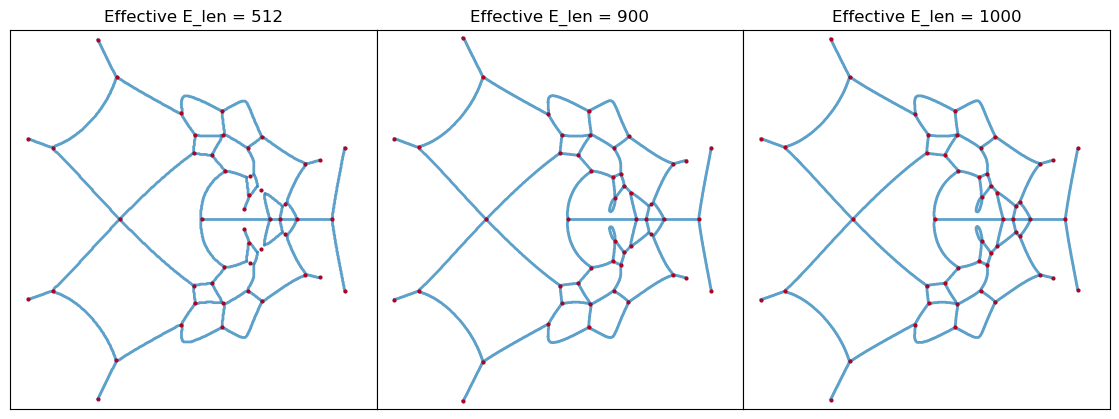

In [25]:
fig, ax = plt.subplots(1,3, figsize=(11,4), sharex=True, sharey=True,
                          gridspec_kw={'hspace':.0, 'wspace':.0})
for i, graph in enumerate([sg_c_default, sg_c_Elen, sg_c_Esplit]):
    pos_dict = {i[0]: (i[1][1], i[1][0]) for i in graph.nodes(data='o')}
    # nx.draw_networkx(graph, pos=pos_dict, ax=ax[i],
    #                 node_size=5, node_color='#A60628', with_labels=False, 
    #                 width=2, edge_color='#348ABD')
    for (s, e, key, ps) in graph.edges(keys=True, data='pts'):
        ax[i].plot(ps[:,1], ps[:,0], '-', c='#348ABD', lw=2, alpha=0.8)
    nodes = graph.nodes()
    ps = np.array([nodes[i]['o'] for i in nodes])
    ax[i].plot(ps[:,1], ps[:,0], 'o', c='#A60628', ms=2)
    ax[i].set(xlim=Emaxes[:2], ylim=Emaxes[2:])
    ax[i].set(xticks=[], yticks=[])
    ax[i].set_title(f'Effective E_len = {graph.graph["E_len"]}')

plt.tight_layout(pad=.01, h_pad=.0, w_pad=.0)
# plt.savefig('./assets/adaptive_resolution.pdf', transparent=True)
plt.savefig('./assets/adaptive_resolution.png', dpi=300, transparent=True)
plt.show()

To obtain the images of spectral potential, DOS, and the binary mask of the spectral graph, call `spectral_images_adaptive_resolution`.

Note that `spectral_images_adaptive_resolution` has `E_split` where as `spectral_images` does not.

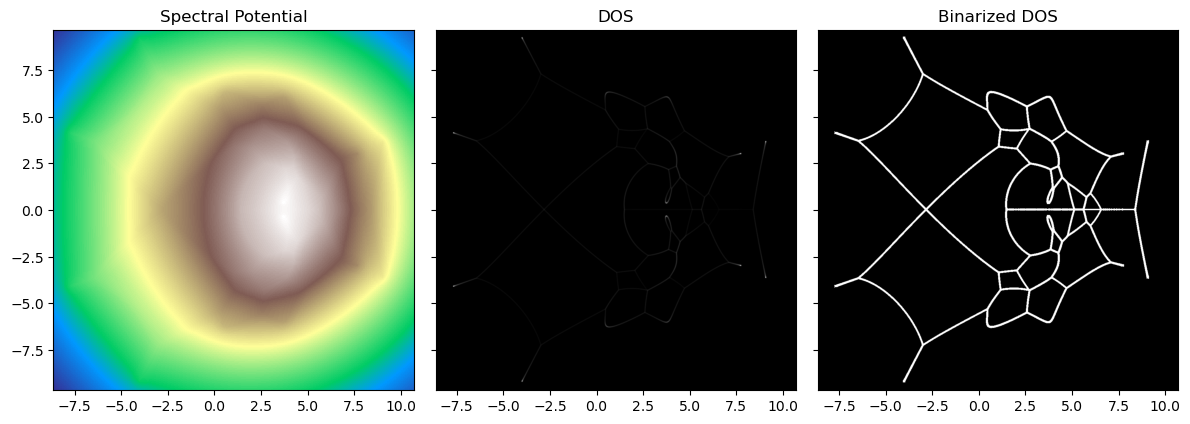

In [7]:
binarized_DOS, Phi, DOS = p2g.spectral_images_adaptive_resolution(cc, 
                                    E_max=Emaxes, E_len=200, E_splits=5)
fig, ax = plt.subplots(1,3, figsize=(12,4), sharex=True, sharey=True)

ax[0].imshow(Phi, cmap='terrain', aspect='equal', extent=Emaxes)
ax[0].set_title('Spectral Potential')
ax[1].imshow(DOS, cmap='gray', aspect='equal', extent=Emaxes)
ax[1].set_title('DOS')
ax[2].imshow(binarized_DOS, cmap='gray', aspect='equal', extent=Emaxes)
ax[2].set_title('Binarized DOS')

plt.tight_layout()
# plt.savefig('./assets/adaptive_resolution_DOS.pdf', transparent=True)
plt.savefig('./assets/adaptive_resolution_images.png', dpi=300, transparent=True)
plt.show()

## Spectral Graph Gallery

here we reproduce FIG.1 in the companion paper

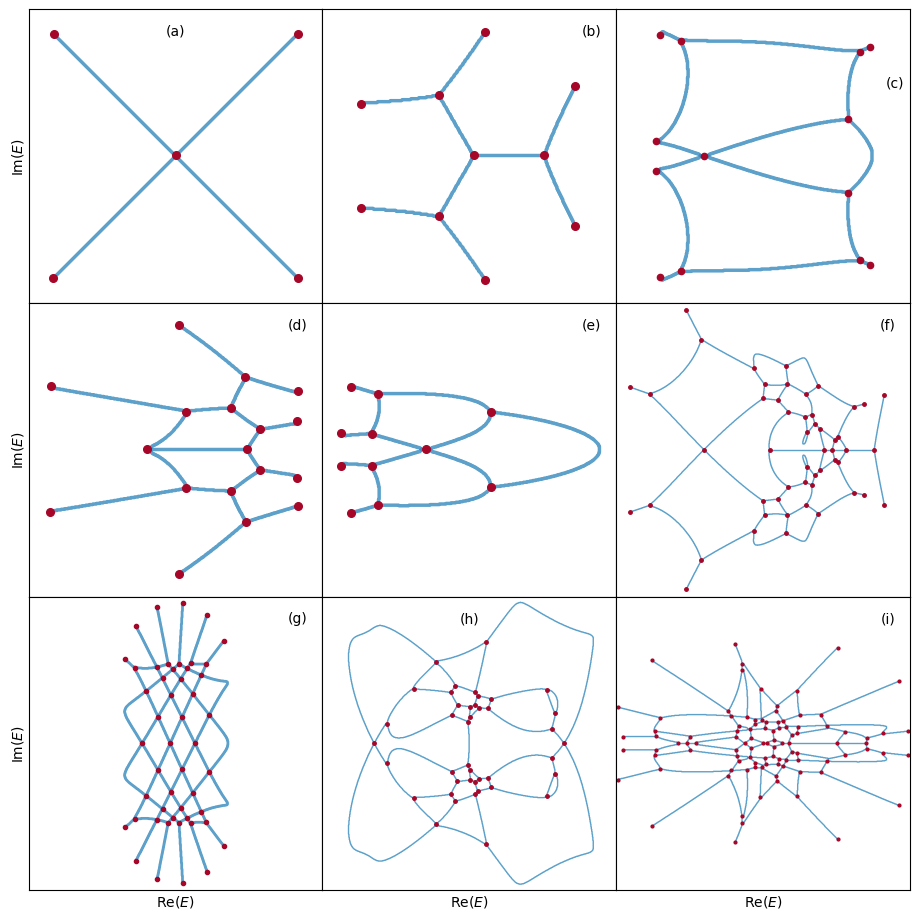

In [ ]:
coeff_demo = [
    [-1,0,0,1,1,0,0],
    [0,0,1,0,-1,1,0,0,-1],
    [1,.8,-.6,-.2,0,.1,.6,-.8,1],
    [-3,0,1,3,-3,0,2,-1,2,-3,-3],
    [1,.4,1,.1,0,0,.2,-.4,1],
    [-2,0,-1,0,1,-2,2,0,1,0,2,0,1,0,-2,-2,2,1,2,-2,0],
    [0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,0,0,1],
    [0,2,-1,2,1,2,-1,-1,-1,-2,1,-1,0,0,1,-2,2,2,-2,-2,1],
    [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-1,-1,1]
]

# marker sizes
msize = [5.5, 5.5, 4.5, 5.5, 5.5, 2.5, 3, 2.5, 2]
# line widths
lwidth = [2.5,2.5,2.5,2.5,2.5,1,2,1,1]
# `E_len`
elen = [300, 300, 250, 250, 250, 250, 250, 250, 750]
# `E_splits`
split = [1,1,2,2,2,4,3,3,1]
# `contract_threshold` (edges shorter than this 
# threshold will be contracted, unit is pixel)
thld = [None, None, 20, 20, 20, 10, 10, 10, 10]

fig, ax = plt.subplots(3, 3, figsize=(9, 9))
for i, ax in enumerate(ax.flat):
    # convert to numpy array for numba safety
    c = np.array(coeff_demo[i])
    # auto-demarcation of the E_maxes
    emaxes = p2g.auto_Emaxes(c)
    graph = p2g.spectral_graph(c, E_max=emaxes, E_len=elen[i],
                               E_splits=split[i], contract_threshold=thld[i])

    for (s, e, key, ps) in graph.edges(keys=True, data='pts'):
        ax.plot(ps[:,1], ps[:,0], '-', c='#348ABD', lw=lwidth[i], alpha=0.8)
    nodes = graph.nodes()
    ps = np.array([nodes[i]['o'] for i in nodes])
    ax.plot(ps[:,1], ps[:,0], 'o', c='#A60628', ms=msize[i])
    ax.set(xlim=emaxes[:2], ylim=emaxes[2:])
    ax.set(xticks=[], yticks=[])

    if i in [2]:
        ax.text(.98, 0.75, f'({chr(97+i)})', ha='right', va='center',
                transform=ax.transAxes, fontsize=10)
    elif i in [0,7]:
        ax.text(0.5, 0.95, f'({chr(97+i)})', ha='center', va='top',
                transform=ax.transAxes, fontsize=10)
    else:
        ax.text(0.95, 0.95, f'({chr(97+i)})', ha='right', va='top',
                transform=ax.transAxes, fontsize=10)

    if i % 3 == 0: ax.set_ylabel('Im($E$)', labelpad=2)
    if i > 5: ax.set_xlabel('Re($E$)', labelpad=2)

plt.tight_layout(pad=.005, h_pad=.0, w_pad=.0)
# plt.savefig('./assets/SGs_demo.pdf', transparent=True)
plt.savefig('./assets/SGs_demo.png', dpi=400, transparent=True)
plt.show()

## Multi-band Spectral Graph

Take a multi-band characteristic polynomial as an example:
$$P(E,z) = z^{-1} + 1/2 E z - E^{2} + z^2$$
whose minimal Hamiltonian is
$$
h(z) = \begin{pmatrix}
1/2 z & z^2+z^{-1} \\
1 & 0
\end{pmatrix}
$$
where the phase factor is defined as $z:=e^{ik}$.

`poly2graph` only takes in **symmetric** (rectangular) coefficient *matrix* where the middle element is the constant term (i.e. the coefficient of $z^0 E^0$):
$$\mathbf{c} = \begin{pmatrix}
\ddots & \vdots & \vdots & \vdots & \vdots & \vdots & \cdots \\
\cdots & c(z^{-2}E^{-2}) & c(z^{-1}E^{-2}) & c(z^0E^{-2}) & c(z^1E^{-2}) & c(z^2E^{-2}) & \cdots \\
\cdots & c(z^{-2}E^{-1}) & c(z^{-1}E^{-1}) & c(z^0E^{-1}) & c(z^1E^{-1}) & c(z^2E^{-1}) & \cdots \\
\cdots & c(z^{-2}E^0) & c(z^{-1}E^0) & {\color{orange} c(z^0E^0)} & c(z^1E^0) & c(z^2E^0) & \cdots \\
\cdots & c(z^{-2}E^1) & c(z^{-1}E^1) & c(z^0E^1) & c(z^1E^1) & c(z^2E^1) & \cdots \\
\cdots & c(z^{-2}E^2) & c(z^{-1}E^2) & c(z^0E^2) & c(z^1E^2) & c(z^2E^2) & \cdots \\
\cdots & \vdots & \vdots & \vdots & \vdots & \vdots & \ddots
\end{pmatrix}$$

Thus for this particular example, its coefficient matrix is:
$$c=\begin{pmatrix}
0 & 0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 1 \\
0 & 0 & 0 & 1/2 & 0 \\
0 & 0 & -1 & 0 & 0
\end{pmatrix}$$

Note that `auto_Emaxes` and `E_splits>1` are not yet supported for multi-band polynomials.

C=
 [[ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0. ]
 [ 0.   1.   0.   0.   1. ]
 [ 0.   0.   0.   0.5  0. ]
 [ 0.   0.  -1.   0.   0. ]]


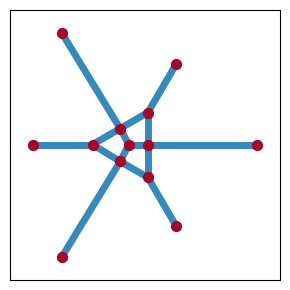

In [ ]:
C = np.zeros((5,5))
C[2,1] = 1; C[2,-1] = 1; C[-2,-2] = 1/2; C[-1,2] = -1
print('C=\n', C)

### the spectral graph
Sg = p2g.spectral_graph(C, E_max=3)
fig, ax = plt.subplots(figsize=(3, 3))
pos_dict = {i[0]: (i[1][1], i[1][0]) for i in Sg.nodes(data='o')}
nx.draw_networkx(Sg, pos=pos_dict, ax=ax,
                 node_size=50, node_color='#A60628', with_labels=False, 
                 width=5, edge_color='#348ABD')
plt.tight_layout()
# plt.savefig('./assets/spectral_graph_multi_band.pdf', transparent=True)
plt.savefig('./assets/spectral_graph_multi_band.png', dpi=300, transparent=True)
plt.show()